In [ ]:
from google.colab import drive

import os, csv
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.utils import np_utils
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/Mydrive')


Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


In [ ]:
!unzip "/content/Mydrive/MyDrive/photos.zip" -d "/content"

Archive:  /content/Mydrive/MyDrive/photos.zip
warning [/content/Mydrive/MyDrive/photos.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/Mydrive/MyDrive/photos.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace /content/photos/abomasnow/pokemonabomasnow0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
type_mapping = {} # pokemon type (string) => pokemon type (integer)
type_mapping_reversed = {} # pokemon type (integer) => pokemon type (string)
pokemon_type_mapping = {} # pokemon name => pokemon type1 (integer)

types = ['Fire', 'Water', 'Normal','Grass']

i = 0
with open('/content/Mydrive/MyDrive/pokemon.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip header
    for row in reader:
        if row[1] in types or (len(row) > 2 and row[2] in types):
            if row[1] in types:
                if row[1] not in type_mapping:
                    type_mapping[row[1]] = i
                    type_mapping_reversed[i] = row[1]
                    i += 1
                pokemon_type_mapping[row[0]] = type_mapping[row[1]]
            if len(row) > 2 and row[2] in types:
                if row[2] not in type_mapping:
                    type_mapping[row[2]] = i
                    type_mapping_reversed[i] = row[2]
                    i += 1
                pokemon_type_mapping[row[0]] = type_mapping[row[2]]

In [ ]:

# original jpgs are (120 x 120 x 3) while original pngs are (120 x 120 x 4)
# change all pngs so that they are (120 x 120 x 3) and convert to jpg
# probably better to convert png -> jpg rather than jpg -> png
# because removing the alpha channel doesn't remove info (png -> jpg)
# but adding the alpha channel adds unnecessary info (jpg -> png)

# i = 0
# for filename in os.listdir('images'):
#     if filename.endswith(".png"):
#         im = Image.open(f'images/{filename}').convert('RGBA')
#         pokemon_name = filename[:-4]
#         background = Image.new("RGB", im.size, (255, 255, 255))
#         background.paste(im, mask=im.split()[-1])
#         name=f'images/{pokemon_name}.jpg'
#         background.save(name, 'JPEG')
# #         os.remove(f'images/{filename}') # delete original png image
#         i += 1

# print(f'{i} images converted')


In [ ]:
# feature matrix will have 43200 columns
directory = '/content/photos'

X = []
y = []
z = []

for pokemon_name in tqdm(pokemon_type_mapping.keys()):
#             print('Loading images for ', pokemon_name)
    for image_path in os.listdir(os.path.join(directory,pokemon_name)):
#                 i = mpimg.imread(f'images/{pokemon_name}.jpg
        i = Image.open(os.path.join(directory,pokemon_name,image_path))  
#                 i = mpimg.imread(os.path.join(directory,pokemon_name,image_path))
        if np.array(i).shape != (120,120, 3):
#                     print('resizing and converting image', image_path, np.array(i).shape)
            i = i.convert('RGB')
            i = i.resize((120,120))
                
        i = np.array(i)
                
        X.append(i)
        y.append(pokemon_type_mapping[pokemon_name])
        z.append(image_path)

100%|██████████| 391/391 [00:23<00:00, 16.89it/s]


In [ ]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.25, random_state=5)

y_train = np_utils.to_categorical(y_train, len(types))
y_test = np_utils.to_categorical(y_test, len(types))

# convert to numpy arrays so keras won't complain
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model = Sequential()

imported_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(120,120,3),
                   pooling='avg',classes=len(types),
                   weights='imagenet')
# for layer in imported_model.layers:
#         layer.trainable=False

model.add(imported_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
fitted_model = model.fit(X_train, y_train, validation_split=0.33, epochs=20, verbose=1)

Epoch 1/20
599/599 [==============================] - 55s 39ms/step - loss: 0.9433 - accuracy: 0.6337 - val_loss: 6.2525 - val_accuracy: 0.3295
Epoch 2/20
599/599 [==============================] - 19s 32ms/step - loss: 0.7401 - accuracy: 0.7226 - val_loss: 6.2076 - val_accuracy: 0.2724
Epoch 3/20
599/599 [==============================] - 19s 32ms/step - loss: 0.6508 - accuracy: 0.7574 - val_loss: 3.1367 - val_accuracy: 0.4045
Epoch 4/20
599/599 [==============================] - 19s 32ms/step - loss: 0.5674 - accuracy: 0.7933 - val_loss: 2.8626 - val_accuracy: 0.4299
Epoch 5/20
599/599 [==============================] - 19s 32ms/step - loss: 0.5037 - accuracy: 0.8151 - val_loss: 3.4939 - val_accuracy: 0.4364
Epoch 6/20
599/599 [==============================] - 19s 32ms/step - loss: 0.4365 - accuracy: 0.8420 - val_loss: 3.7778 - val_accuracy: 0.4387
Epoch 7/20
599/599 [==============================] - 19s 32ms/step - loss: 0.3908 - accuracy: 0.8629 - val_loss: 2.3094 - val_accuracy:

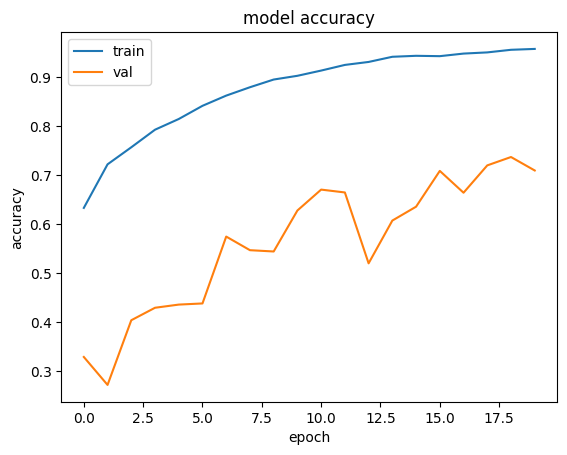

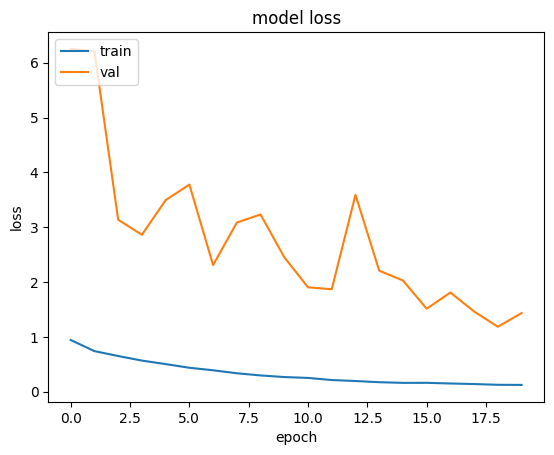

In [ ]:
# summarize history for accuracy
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluation:
score = model.evaluate(X_test, y_test, verbose=1)
print('The accuracy is: ', score[1])

298/298 [==============================] - 2s 7ms/step - loss: 1.4745 - accuracy: 0.7074
The accuracy is:  0.7074015736579895


In [ ]:
y_predict = model.predict(X_test)

298/298 [==============================] - 2s 6ms/step


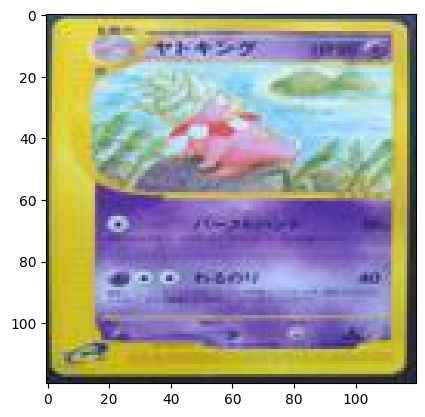

pokemonslowking58.jpeg is Water. model predicted Water


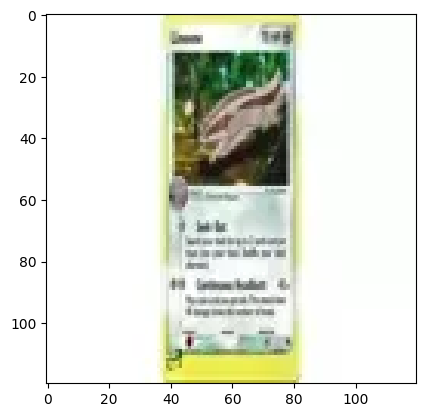

pokemonlinoone97.webp is Normal. model predicted Water


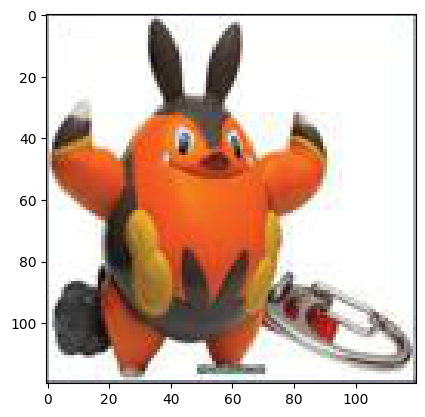

pokemonpignite71.jpeg is Fire. model predicted Fire


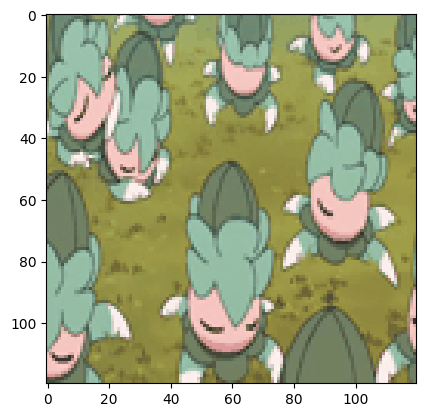

pokemonfomantis97.gif is Grass. model predicted Water


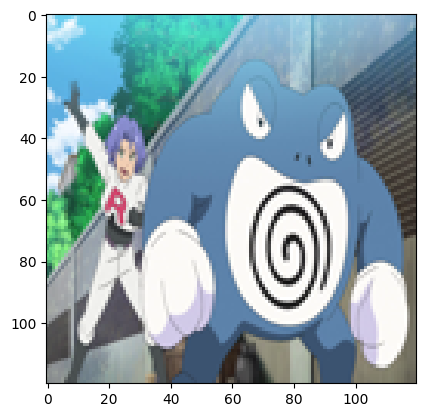

pokemonpoliwrath35.png is Water. model predicted Water


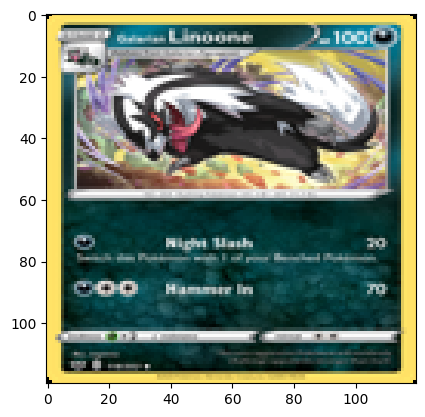

pokemonlinoone8.png is Normal. model predicted Normal


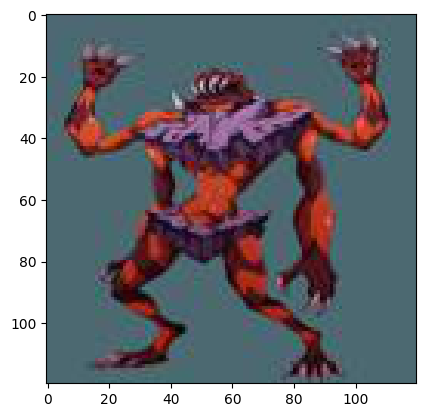

pokemonbarbaracle92.jpeg is Water. model predicted Fire


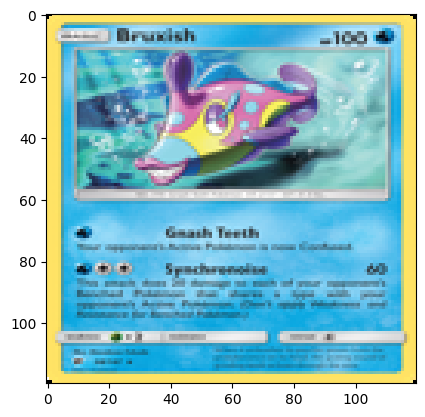

pokemonbruxish7.png is Water. model predicted Water


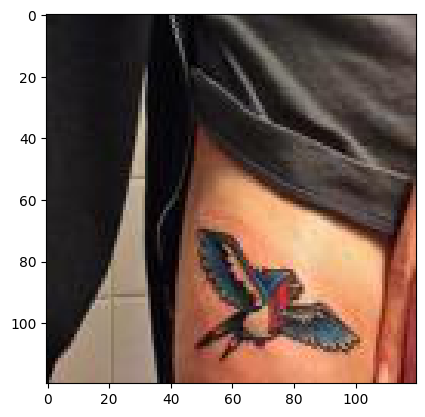

pokemonswellow20.jpeg is Normal. model predicted Water


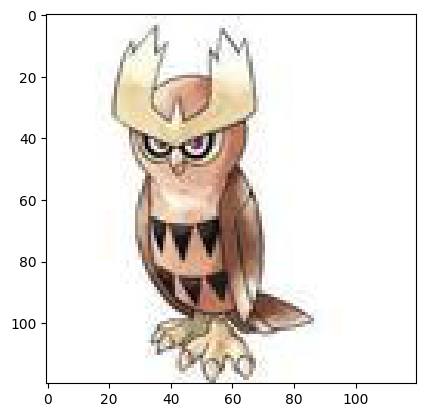

pokemonnoctowl4.jpeg is Normal. model predicted Normal


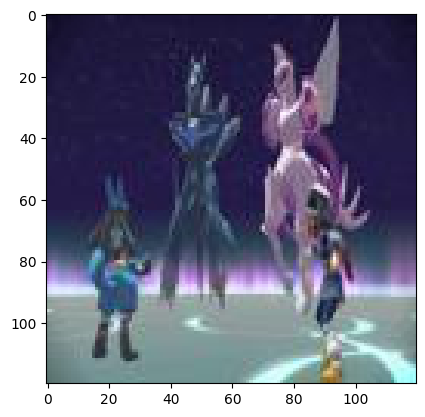

pokemonarceus20.jpeg is Normal. model predicted Water


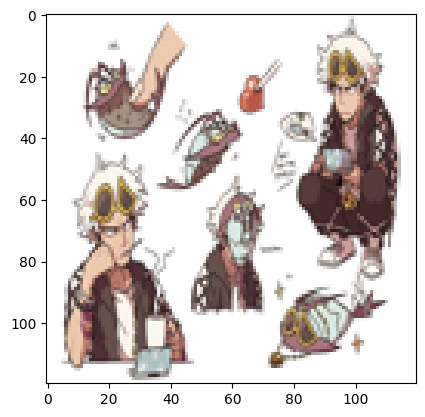

pokemonwimpod56.png is Water. model predicted Normal


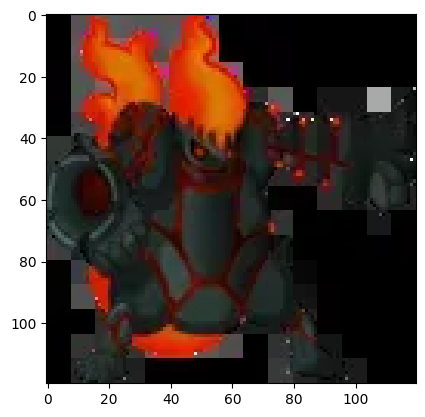

pokemonmagmortar26.webp is Fire. model predicted Fire


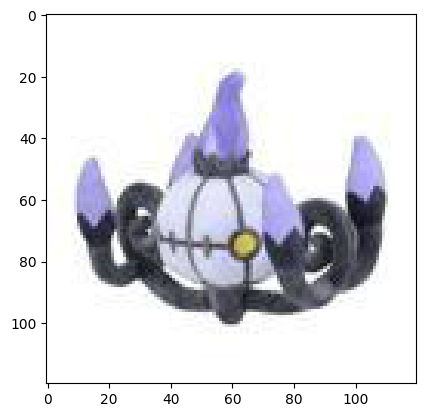

pokemonchandelure18.jpeg is Fire. model predicted Fire


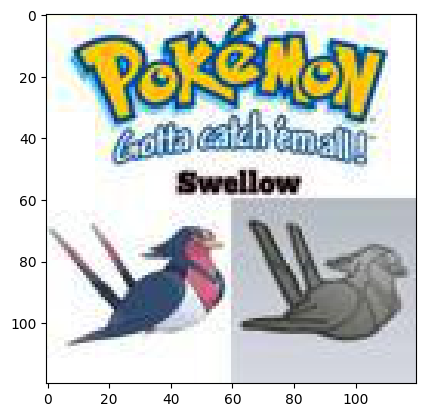

pokemonswellow96.jpeg is Normal. model predicted Water


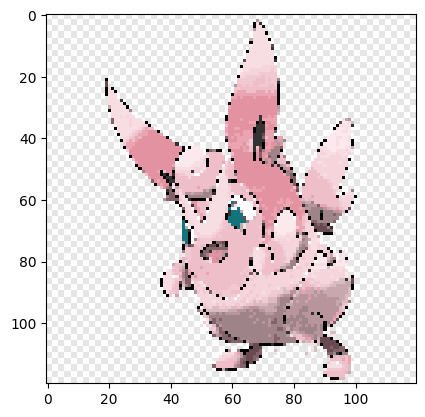

pokemonigglybuff55.png is Normal. model predicted Normal


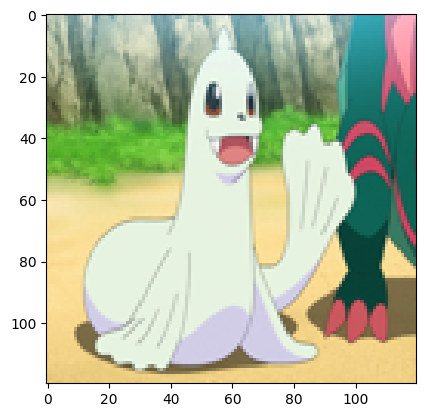

pokemondewgong4.png is Water. model predicted Water


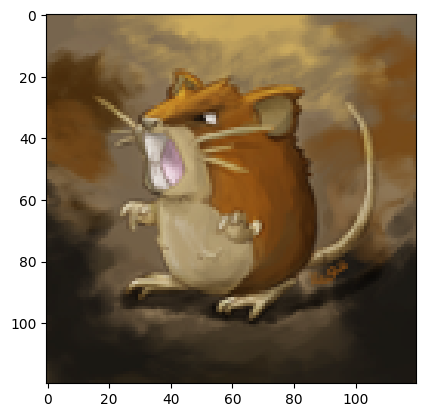

pokemonraticate53.png is Normal. model predicted Normal


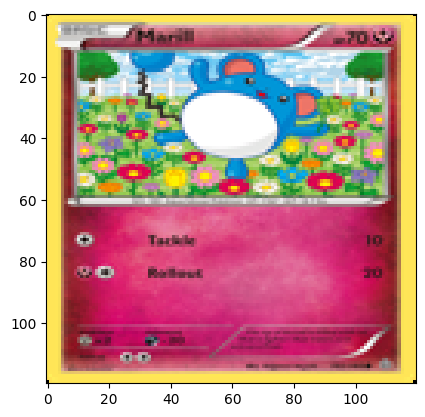

pokemonmarill67.png is Water. model predicted Fire


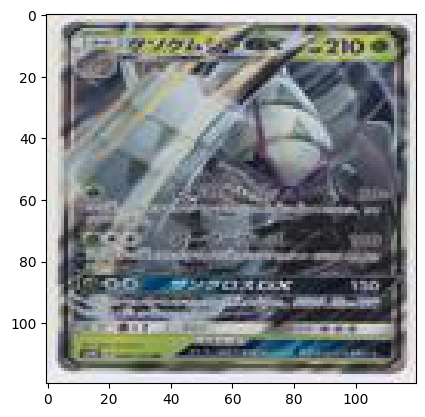

pokemongolisopod75.jpeg is Water. model predicted Water


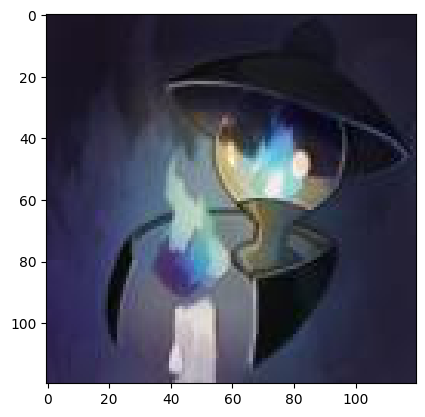

pokemonlampent87.jpeg is Fire. model predicted Grass


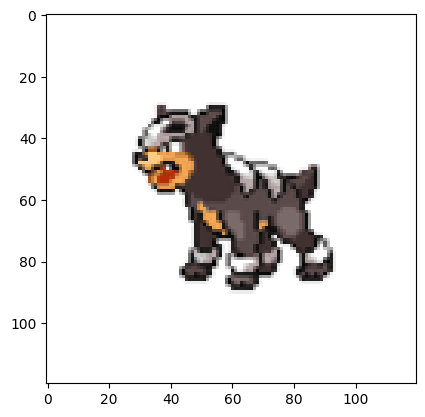

pokemonhoundour97.gif is Fire. model predicted Fire


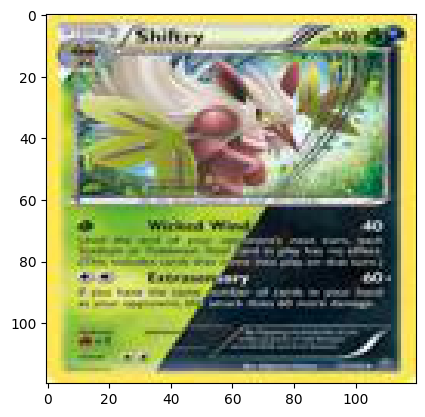

pokemonnuzleaf97.jpeg is Grass. model predicted Grass


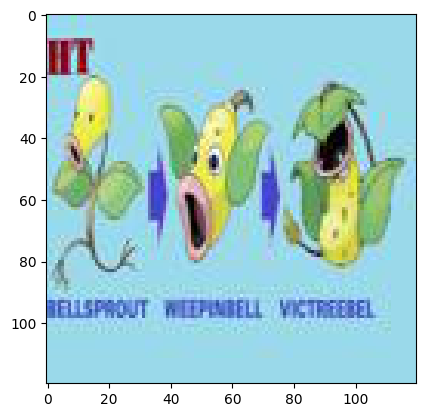

pokemonbellsprout74.jpeg is Grass. model predicted Water


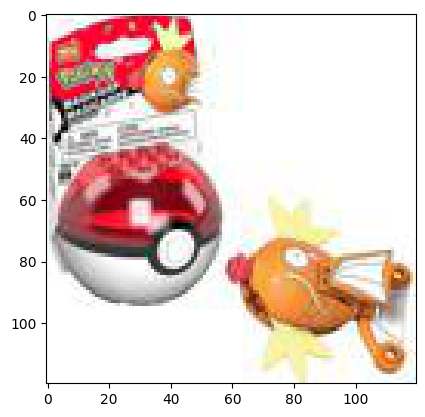

pokemonmagikarp14.jpeg is Water. model predicted Water


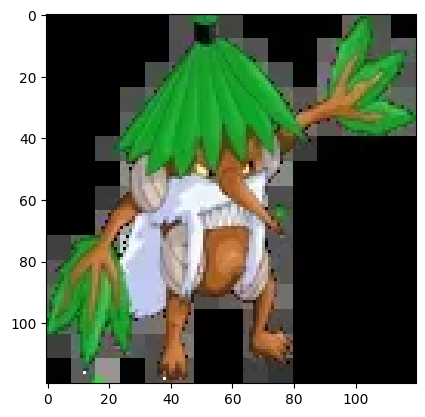

pokemonshiftry39.webp is Grass. model predicted Grass


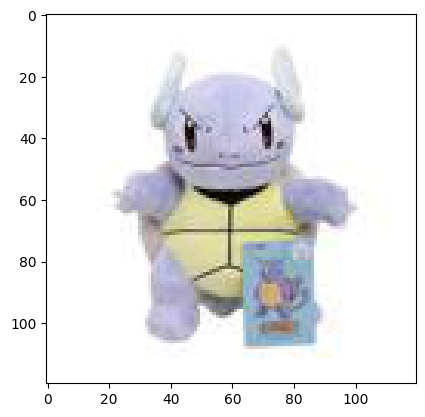

pokemonwartortle59.jpeg is Water. model predicted Water


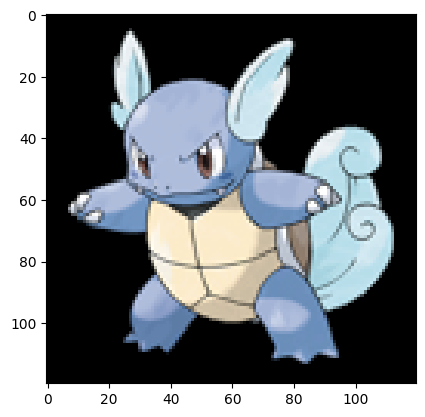

pokemonwartortle0.png is Water. model predicted Water


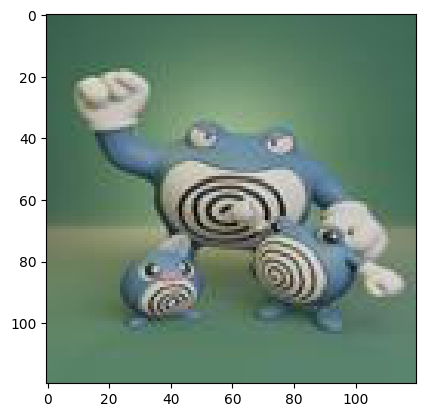

pokemonpoliwrath76.jpeg is Water. model predicted Water


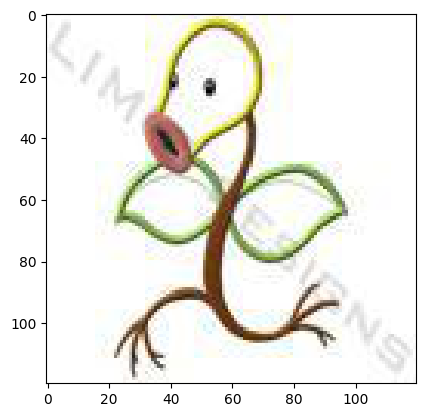

pokemonbellsprout31.jpeg is Grass. model predicted Water


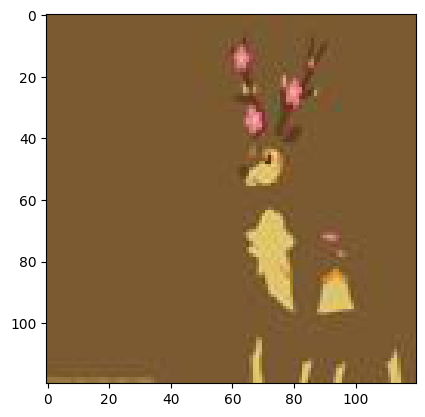

pokemonsawsbuck66.jpeg is Grass. model predicted Normal


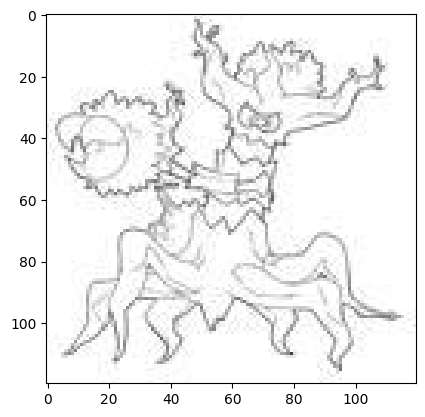

pokemontrevenant85.jpeg is Grass. model predicted Water


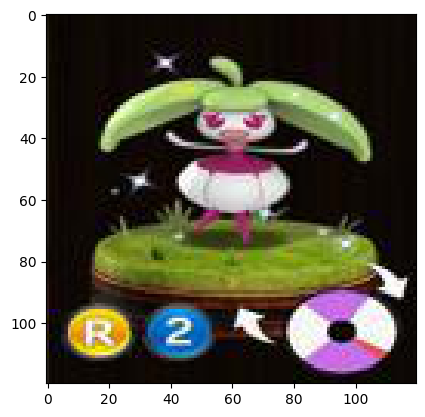

pokemonsteenee76.jpeg is Grass. model predicted Grass


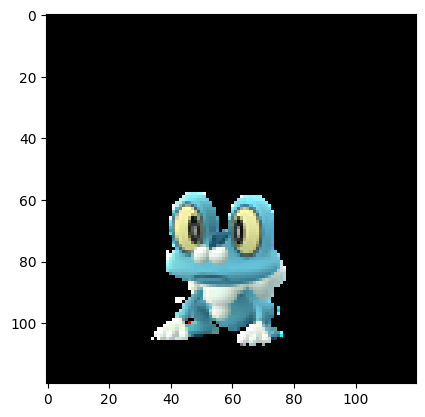

pokemonfroakie5.png is Water. model predicted Water


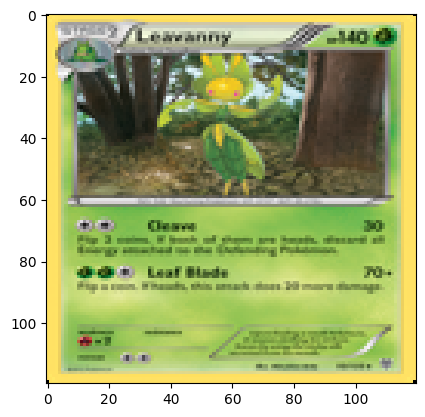

pokemonleavanny24.png is Grass. model predicted Grass


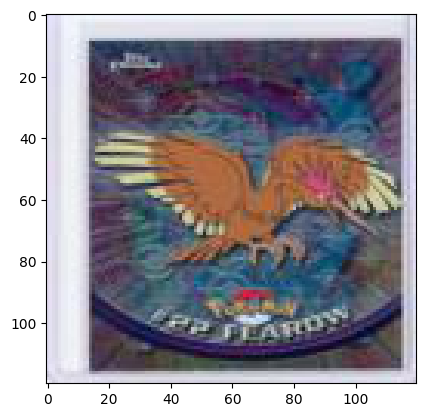

pokemonfearow81.jpeg is Normal. model predicted Normal


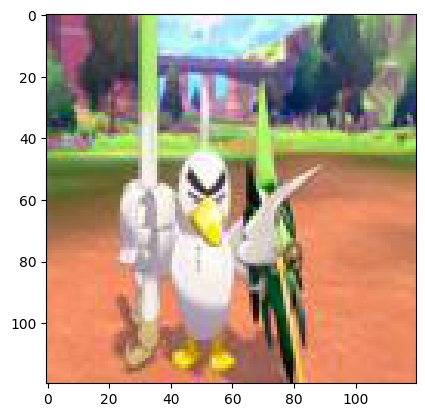

pokemonfarfetchd77.jpeg is Normal. model predicted Grass


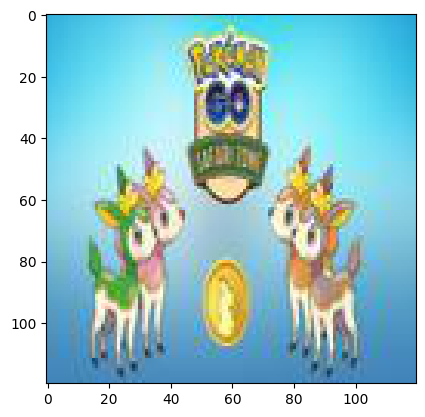

pokemondeerling42.jpeg is Grass. model predicted Water


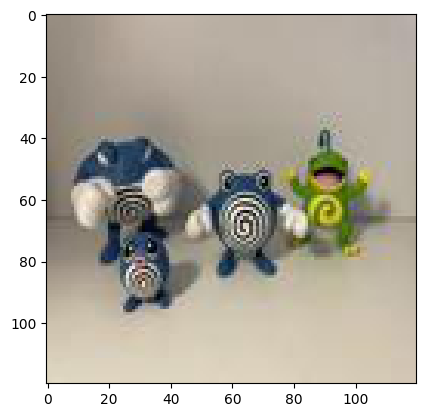

pokemonpoliwrath68.jpeg is Water. model predicted Water


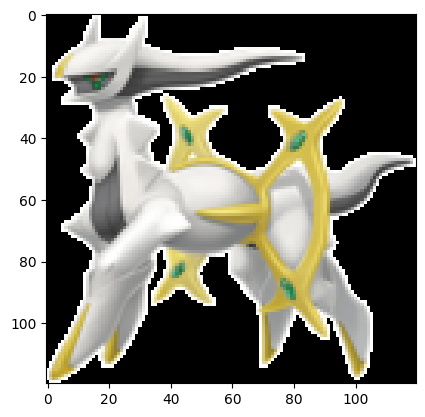

pokemonarceus16.png is Normal. model predicted Water


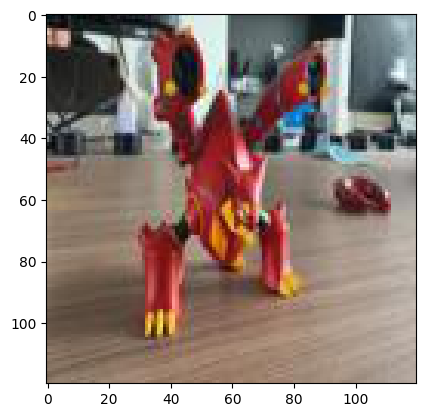

pokemonvolcanion28.jpeg is Water. model predicted Water


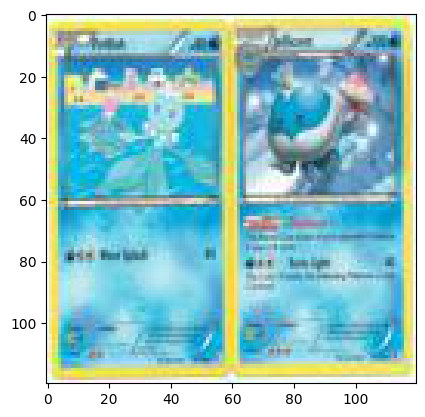

pokemonjellicent60.jpeg is Water. model predicted Water


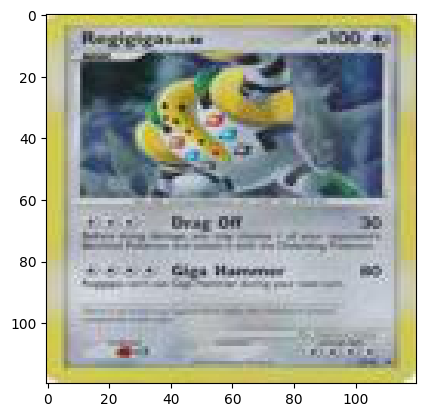

pokemonregigigas24.jpeg is Normal. model predicted Water


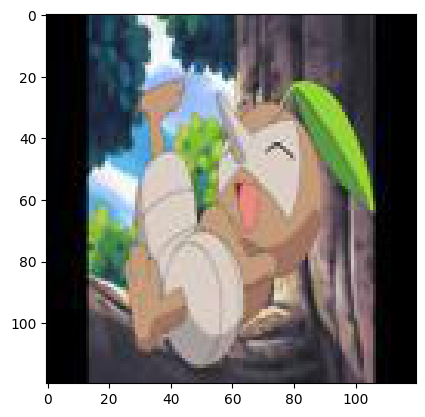

pokemonnuzleaf26.jpeg is Grass. model predicted Grass


KeyError: ignored

In [ ]:
import re
for y, z in zip(y_predict, z_test):
    pokemon_name = re.search(r'pokemon(\D*)', z).group(1)
#     print(pokemon_name)
    actual_type = type_mapping_reversed[pokemon_type_mapping[pokemon_name]]
    predicted_type = type_mapping_reversed[np.argmax(y)]

    %matplotlib inline
#     i = mpimg.imread(f'images/{z}.jpg')
    i = mpimg.imread(f'photos/{pokemon_name}/{z}')
    plt.imshow(i)
    plt.show()

    print(f'{z} is {actual_type}. model predicted {predicted_type}')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
print(z)